### CPSC 672 Network Project

In [63]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from scipy import spatial
import csv
import collections as ct
from tqdm.notebook import tqdm
%run AdditionalClasses/NullCompare.ipynb import *
%run AdditionalClasses/GraphFromFile.ipynb import *
%matplotlib inline

### Data

The following few cells read in our data from a excel spreadsheet and organize them into a few arrays:
- stock_symbols contains all the actual stock names
- dates contains all the column headings (which are dates) from Feb 2010 to Dec 2021

In [20]:
df_total = pd.read_excel('data/all_data.xlsx', sheet_name='percentChange')
df_subset = pd.read_excel('data/subset_data.xlsx',sheet_name='percentChange')

In [21]:
stock_symbols = []
for stock in df_total['Stock']:
    stock_symbols.append(stock)

dates = df_total.columns.values
dates = dates[2:]

### Calculating links

To get the links between any two stocks, we use cosine similarity to determine how correlated two stocks are. The formula for cosine similarity is as follows:
$$ 
x = {1 - \frac{u \cdot v}{||u|| * ||v||}  }
$$
                            
the getSimilarities() functions do just that by comparing every stock, with every other stock, for any input date (column). Note one of the functions calculates this over a 12 month period (Yearly) whereas the other function uses the total dataset.

In [6]:
def getSimilaritiesTotal(dataFrame):
    similarities = []
    for i in tqdm(range(len(dataFrame))):
        for j in range(i+1,len(dataFrame)):
            first_stock = dataFrame.iloc[i,2:]
            second_stock = dataFrame.iloc[j,2:]
            result = 1 - spatial.distance.cosine(first_stock,second_stock)
            similarities.append((stock_symbols[i], stock_symbols[j], result))
    return similarities

In [7]:
def getSimilaritiesYearly(date,dataFrame):
    similarities = []
    elems = len(dataFrame[date])
    start_col = (np.where(dates == date)[0][0]) + 2 # plus 2 is for indexing away from stock symbol & sector
    end_col = start_col + 12
    for i in tqdm(range(elems)):
        for j in range(i+1,elems):
            first_stock = dataFrame.iloc[i,start_col:end_col]
            second_stock = dataFrame.iloc[j,start_col:end_col]
            result = 1-spatial.distance.cosine(first_stock,second_stock)
            similarities.append((stock_symbols[i], stock_symbols[j], result))
    return similarities

In [8]:
def getAllYears(dataFrame):
    i = 0
    arr = []
    start_date = dates[i]
    curr_year = start_date.year
    while(curr_year < 2021):
        yearly_similarity = getSimilaritiesYearly(start_date,dataFrame)
        arr.append((start_date,yearly_similarity))
        curr_year+=1
        i+=12
        start_date = dates[i]
    return arr

### Getting the total and Yearly similarities

In [ ]:
total_similarities = getSimilaritiesTotal(df_total)

In [ ]:
yearly_similarites = getAllYears(df_total)

### Exporting
At this point all the stock symbols are exported to csv files, each year has it's own specific set of links. And there is also a csv that contains the total similarity across the entire dataset

In [9]:
def writeStocks():
    with open('data/stocks.csv','w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["ID	label"])
        for stock in stock_symbols:
            writer.writerow([str(stock_symbols.index(stock))+"\t"+stock])

In [10]:
def writeTotal(threshold):
    with open('data/links_total.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Source	Target	Weight"])
        for link in total_similarities:
            first_stock_index = str(stock_symbols.index(link[0]))
            second_stock_index = str(stock_symbols.index(link[1]))
            link_weight = link[2]
            if(abs(link_weight) > threshold):
                writer.writerow([first_stock_index+"\t"+second_stock_index+"\t"+str(link_weight)])

In [11]:
def writeYearly(yearly_calc,threshold):
    for year in yearly_calc:
        curr_year = year[0].year
        links = year[1]
        file_name = 'data/links_'+str(curr_year)+'.csv'
        with open(file_name, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Source	Target	Weight"])
            for link in links:
                first_stock_index = str(stock_symbols.index(link[0]))
                second_stock_index = str(stock_symbols.index(link[1]))
                link_weight = link[2]
                if(abs(link_weight) > threshold):
                    writer.writerow([first_stock_index+"\t"+second_stock_index+"\t"+str(link_weight)])

In [ ]:
writeStocks()
writeTotal(0.5)

In [ ]:
writeYearly(yearly_similarites,0.6)

### Visualizing the Data
Now that the data has been processed and exported into their own csv's , we can begin to do some visualiation and more graph theory related calculations.
Also, due to lack of computational resources, we have decided to reduce the number of links to 100,000 . The following two functions take the original csv's and take the strongest 100,000 links and save them. Links who do not make the cut are simply discarded.

In [5]:
def filterYearly(num_of_links):
    for i in range(2010,2021):
        df_link=pd.read_csv("data/links_"+str(i)+".csv",delimiter="\t")
        df_link = df_link.sort_values(by=['Weight'],key=abs,ascending=False,ignore_index=True)
        df_link[:num_of_links].to_csv("data/Filtered/links_"+str(i)+".csv",sep='\t',index=False)

In [6]:
def filterTotal(num_of_links):
        df_link=pd.read_csv("data/links_total.csv",delimiter="\t")
        df_link = df_link.sort_values(by=['Weight'],key=abs,ascending=False,ignore_index=True)
        df_link[:num_of_links].to_csv("data/Filtered/links_total.csv",sep="\t",index=False)

In [ ]:
filterYearly(100000)
filterTotal(100000)


In [14]:
Yearly_Graphs = []
for i in range(2010,2021):
    G =GraphFromFile().GraphFromFileYearlyAbsWeights(i)
    Yearly_Graphs.append(G)

In [15]:
Total_Graph = []
Total_Graph.append(GraphFromFile().GraphFromFileTotalAbsWeights())


In [16]:
def PlotGraphDegDistribution(Graph_list):
    fig = plt.figure(figsize=(6,4))
    plt.xlabel(r"degree $k$", fontsize=16)
    plt.ylabel(r"$P(k)$", fontsize=16)
    for i in range(len(Graph_list)):
        G = Graph_list[i]
        N = len(G)
        L = G.size()
        degrees = [G.degree(node,weight='weight') for node in G]
        kmin = min(degrees)
        kmax = max(degrees)

        # Get 10 logarithmically spaced bins between kmin and kmax
        bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num=10)

        # histogram the data into these bins
        density, _ = np.histogram(degrees, bins=bin_edges, density=True)


        # "x" should be midpoint (IN LOG SPACE) of each bin
        log_be = np.log10(bin_edges)
        x = 10**((log_be[1:] + log_be[:-1])/2)
        label = 2010 +i if len(Graph_list) > 1 else "total"
        plt.loglog(x, density, marker='o', label = label,linestyle='none')


        # remove right and top boundaries because they're ugly
        ax = plt.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')

        # Show the plot
    plt.legend()
    plt.show()


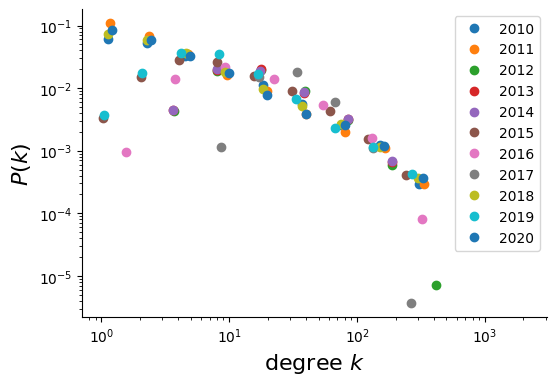

In [17]:
PlotGraphDegDistribution(Yearly_Graphs)           #for ploting total graph degree distribution

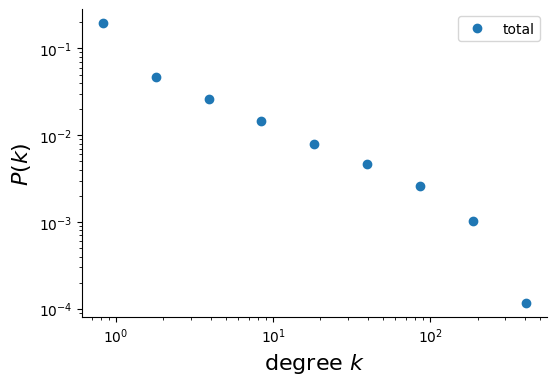

In [18]:
PlotGraphDegDistribution(Total_Graph)             #for ploting total graph degree distribution

In [7]:
G = Total_Graph[0]
CG = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(CG[0])                 # select the biggest connected component

In [8]:
n = NullCompare(G)

In [9]:
C,d = n.CalculateStats()
print("Average Clustering Coefficient: ", C)
print("Average Shortest Path: ", d)

Average Clustering Coefficient:  0.6678847956398628
Average Shortest Path:  2.728443762372391


In [64]:
clustering_ER,short_path_ER = n.ERStats()
print(np.mean(clustering_ER))
print(np.std(clustering_ER))

print(np.mean(short_path_ER))
print(np.std(short_path_ER))

TypeError: NullCompare.ERStats() missing 1 required positional argument: 'iterations'

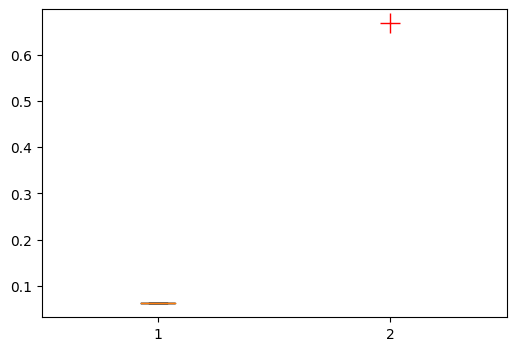

In [13]:
n.ClusteringCoffPlot(clustering_ER,C )


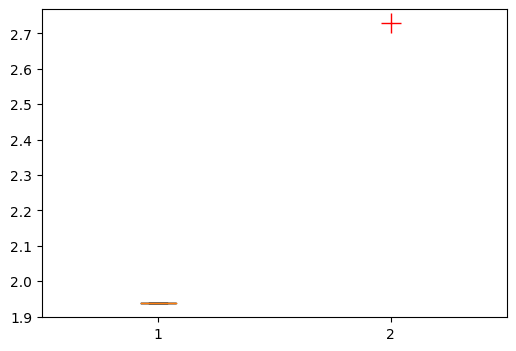

In [14]:
n.ShortPathPlot(short_path_ER,d)

In [ ]:
clustering_DP,short_path_DP = n.DPStats()
print(np.mean(clustering_DP))
 print(np.std(clustering_DP))

print(np.mean(short_path_DP))
print(np.std(short_path_DP))

In [62]:
G = GraphFromFile().GraphFromFileTotalAbsWeights()

In [23]:
sectors = pd.read_excel("data/all_data.xlsx",sheet_name='percentChange')
all_lists = []
for k in sectors['Sector']:
    all_lists.append(str(k))
x1 = (ct.Counter(all_lists)).most_common()
print(x1)


[('Banks', 271), ('Biotechnology', 163), ('Oil, Gas & Consumable Fuels', 128), ('Equity Real Estate Investment Trusts ...', 101), ('Metals & Mining', 95), ('Machinery', 93), ('Electronic Equipment, Instruments & C...', 88), ('Capital Markets', 87), ('Health Care Equipment & Supplies', 87), ('Insurance', 80), ('Semiconductors & Semiconductor Equipment', 75), ('Software', 70), ('Specialty Retail', 63), ('IT Services', 58), ('Commercial Services & Supplies', 57), ('Pharmaceuticals', 56), ('Chemicals', 55), ('Hotels, Restaurants & Leisure', 54), ('Thrifts & Mortgage Finance', 52), ('Communications Equipment', 50), ('Health Care Providers & Services', 48), ('Food Products', 47), ('Media', 47), ('Aerospace & Defense', 43), ('Household Durables', 43), ('Professional Services', 38), ('Energy Equipment & Services', 34), ('Blank Check / SPAC', 32), ('Electrical Equipment', 31), ('Textiles, Apparel & Luxury Goods', 30), ('Electric Utilities', 29), ('Trading Companies & Distributors', 28), ('Real 

In [24]:


temp =sorted(G.degree(G.nodes,weight='weight' ), key=lambda x: x[1], reverse=True)[:100]

lists = []

for t in temp:
    f = sectors.loc[sectors['Stock'] == stock_symbols[int(t[0])]]
    lists.append(f.iloc[0,1])
    print(stock_symbols[int(t[0])])
    print(f.iloc[0,1])
x2 =  (ct.Counter(lists)).most_common()
print(x2)

RVT
Electromedical and Electrotherapeutic...
TY
Aerospace & Defense
GDV
Blank Check / SPAC
EVT
Hotels, Restaurants & Leisure
RMT
Real Estate Management & Development
CSQ
IT Services
USA
Uranium
GAM
Biotechnology
ETO
Biotechnology
ETG
Furnishings, Fixtures & Appliances
BTO
Entertainment
AVK
Pharmaceuticals
CHW
Hotels, Restaurants & Leisure
SCD
Metals & Mining
MCN
Software-Application
LNC
Insurance
LGI
Capital Markets
FFA
Chemicals
PH
Machinery
PFG
Insurance
BDJ
Electronic Equipment, Instruments & C...
GAB
IT Services
ETY
Software-Application
EXG
Software-Application
HON
Industrial Conglomerates
NIE
Consumer Finance
WCC
Trading Companies & Distributors
EMR
Electrical Equipment
PEO
Hotels, Restaurants & Leisure
GL
Insurance
NFJ
Gold
PRU
Insurance
AMP
Capital Markets
C
Banks
CATY
Banks
ASB
Banks
MET
Insurance
EWBC
Banks
ADX
Biotechnology
CR
Machinery
MGU
Biotechnology
CET
Asset Management
SLB
Energy Equipment & Services
DDF
Technology Hardware, Storage & Periph...
PACW
Banks
ASG
Blank Chec

In [25]:
x3 = []
for a,b in x2:
    for c,d in x1:
        if (c == a):
            b = b/d
            if (d > 50):
                x3.append((a,b))
print(sorted(x3 , key=lambda student: student[1], reverse=True))

[('Hotels, Restaurants & Leisure', 0.09259259259259259), ('Insurance', 0.0875), ('Machinery', 0.08602150537634409), ('Capital Markets', 0.06896551724137931), ('Chemicals', 0.05454545454545454), ('Banks', 0.05166051660516605), ('Electronic Equipment, Instruments & C...', 0.045454545454545456), ('Equity Real Estate Investment Trusts ...', 0.039603960396039604), ('IT Services', 0.034482758620689655), ('Biotechnology', 0.03067484662576687), ('Pharmaceuticals', 0.017857142857142856), ('Specialty Retail', 0.015873015873015872), ('Metals & Mining', 0.010526315789473684), ('Oil, Gas & Consumable Fuels', 0.0078125)]


In [75]:
sectors = pd.read_excel("data/all_data.xlsx",sheet_name='percentChange')
sectors2 = pd.read_excel("data/all_data.xlsx",sheet_name='sectors')
c = 0
for t in sectors['Stock']:
        f = sectors2.loc[sectors2['Symbol'] == (t)]
        if (f.empty):
            print(t)
            c +=1
print (c)


ACC
ACH
ADX
AEF
AFB
AGD
AINV
ALJJ
AOD
ASG
AUTO
AVK
AWF
AWP
AXU
BANFP
BBI
BBQ
BCV
BDJ
BDSI
BFK
BFZ
BGR
BGT
BGY
BHK
BHV
BKEP
BKN
BKT
BLE
BLW
BME
BNY
BOE
BPOPM
BRCN
BRW
BTA
BTO
BTZ
BXMX
BYM
CAF
CDR
CEE
CEV
CGO
CHI
CHN
CHSCP
CHW
CHY
CIF
CII
CIK
CLBS
CLM
CMU
CRF
CSQ
CTEK
CTXS
CUBA
CXE
CXH
CYCCP
DDF
DDT
DEX
DHF
DHY
DMF
DNP
DRE
DSM
DSU
DTF
EAD
ECF
ECOL
EDD
EEA
EFR
EFT
EGF
EHI
EIM
ELY
EMD
EMF
ENDP
ENX
EOD
EOI
EOS
EOT
ERC
ERH
ETB
ETG
ETJ
ETO
ETV
ETW
ETY
EVF
EVG
EVM
EVN
EVOL
EVT
EVV
EXG
FAM
FAX
FCO
FCT
FEN
FEO
FFA
FFC
FGB
FLC
FMN
FMO
FMY
FOF
FRA
FT
FTF
GAB
GAM
GBL
GCV
GDL
GDO
GDV
GF
GGN
GGT
GIM
GJH
GJO
GJS
GLO
GLQ
GLU
GLV
GOF
GPL
GRF
GRX
GSS
GSV
GUT
HBP
HIO
HIX
HNGR
HNW
HOVNP
HPF
HPI
HPS
HQH
HQL
HTD
HTY
HYB
HYT
IAE
IAF
IFN
IGA
IGD
IGI
IGR
IIF
IIM
IIVI
INSI
IQI
IRL
ISBC
JCE
JEQ
JFR
JHI
JHS
JLS
JMM
JOF
JPC
JPS
JQC
JRO
JRS
JSM
KF
KSM
KTF
KTH
KTN
KYN
LEO
LFC
LGI
LJPC
MANT
MAV
MCA
MCI
MCN
MCR
MFD
MFM
MFV
MGF
MGU
MHD
MHF
MHI
MHN
MIN
MIY
MMT
MMU
MNP
MPA
MPV
MQT
MQY
MSD
MUA
MUC
MUE
MUI
MUJ
MVF
MVO
MVT
M

In [61]:
sectors = pd.read_excel("data/all_data.xlsx",sheet_name='percentChange')
all_lists = []
c =0
for k in sectors['Sector']:
    all_lists.append(str(k))
x1 = (ct.Counter(all_lists)).most_common()
print(c)

0
